In [18]:
import logging
import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cm
from rdkit import Chem
sns.set(style="whitegrid")

from dft_descriptors import prepocessing as pp
from dft_descriptors import featurisation as ft

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import xgboost as xgb

logging.basicConfig(level=logging.INFO)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [19]:
df = pd.read_csv("data_csv/Data_test11132021.csv", sep = ',')
# Removing 
vc = df.DOI.value_counts()
doi_above_10 = np.array(vc[vc > 20].index)

indexes = []

for i, row in df.iterrows():
    if row["DOI"] not in doi_above_10:
        indexes.append(i)
        
df = df.drop(indexes)
df = df.reset_index(drop=True)

In [20]:
df2 = pp.preprocess(df)

In [21]:
X, y, DOIs, mechanisms, origins = ft.process_dataframe_dft(df2, data_path="data_csv/")

NoLigand


In [22]:
    # Chemistry world loves t-SNE plots, so let's make it
tX = TSNE().fit_transform(X)

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [41]:
len(np.unique(mechanisms))

11

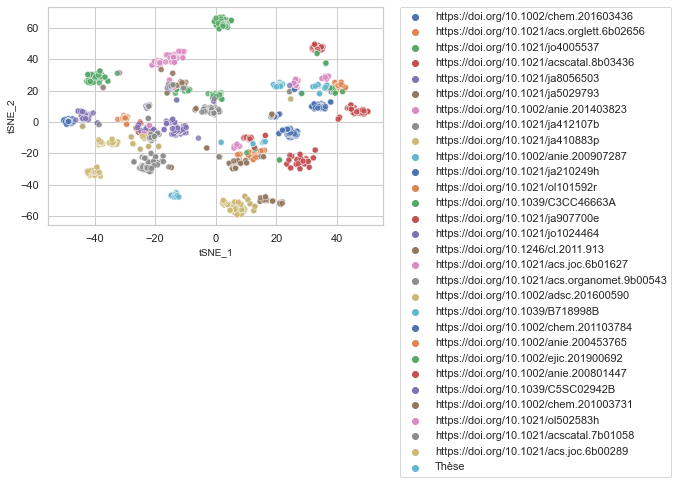

In [44]:
sns.scatterplot(x=tX[:,0], y=tX[:, 1], alpha=0.8, hue=DOIs, palette=sns.color_palette(n_colors=30))
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("tSNE_1", fontsize=10)
plt.ylabel("tSNE_2", fontsize=10)

plt.savefig("tsne_by_DOI.png", dpi=300, format='png', bbox_inches='tight')
#plt.show()

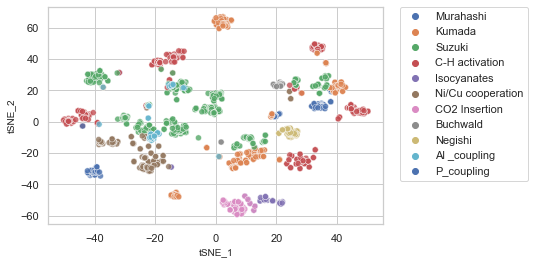

In [43]:
    # Chemistry world loves t-SNE plots, so let's make it
sns.scatterplot(x=tX[:,0], y=tX[:, 1], alpha=0.8, hue=mechanisms, palette=sns.color_palette(n_colors=11))
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("tSNE_1", fontsize=10)
plt.ylabel("tSNE_2", fontsize=10)

plt.savefig("tsne_by_meca.png", dpi=300, format='png', bbox_inches='tight')

In [ ]:
for col in df2.columns:
    df2[col] = df2[col].astype(float, errors = 'raise')
    
    df3=df2.select_dtypes(exclude='object')

    scaler = MinMaxScaler()
    df3 = pd.DataFrame(scaler.fit_transform(df3), columns=df3.columns, index=df3.index)
    
    X, y = df3.loc[:, df3.columns != 'yield'], df3['yield']
    print (f"Number of features: {X.shape[1]}, number of samples: {X.shape[0]}")
    
    zero_std = X.std()[X.std() == 0].index
    display(f"Zero std columns: {len(zero_std)}")
    X = X[X.columns.difference(zero_std)]
    
    dupes = duplicates(X, round=3)
    display(f"Duplicate columns: {len(dupes)}")
    X = X[X.columns.difference(dupes)]
    
    high_corr = correlated(X, threshold=0.99)
    display(f"Correlated features: {len(high_corr)}")
    X = X[X.columns.difference(high_corr)]
    
    print (f"Number of features: {X.shape[1]}, number of samples: {X.shape[0]}")

In [10]:
def duplicates(X, round=None) -> list:
    """Drop duplicate columns in dataframe

    :param X: input dataframe
    :type X: pandas.core.frame.DataFrame
    :param round: decimal point used for rounding. If set the dataframe is scaled with MinMaxScaler \
    and rounded to the given precision, afterward duplicates are removed. This allows to drop duplicates avoiding \
    floating point precision issues
    :type round: int
    :return: list of columns that are duplicates
    """

    X_ = X.copy()
    if round is not None:
        scaler = MinMaxScaler()
        X_ = pd.DataFrame(scaler.fit_transform(X_),
                          columns=X_.columns,
                          index=X_.index)
        X_ = X_.round(round)
    return X_.columns[X_.T.duplicated()].tolist()


def correlated(X, threshold=0.95) -> list:
    """Decorrelate dataframe by finding which columns shall \
    be removed to achieve correlation level below threshold

    :param X: input dataframe
    :type X: pandas.core.frame.DataFrame
    :param threshold: maximum correlation allowed in the frame X
    :type threshold: float
    :return: list of columns to prune in order to achieve desired decorrelation level
    """

    X_ = X.copy()
    N = X_.shape[1]
    corr = X_.corr().abs()

    to_drop = set()
    for i in range(N - 1):
        for j in range(i + 1, N):
            if corr.iloc[i][j] > threshold and i not in to_drop:
                to_drop.add(j)
    return [X_.columns[i] for i in to_drop]


/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


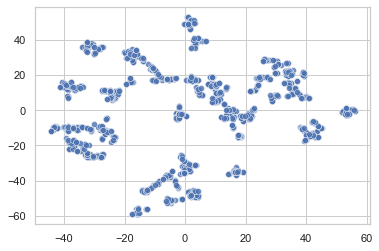

In [11]:
def setup_df(df):
    for col in df.columns:
        df[col] = df[col].astype(float, errors = 'raise')
    
    df2=df.select_dtypes(exclude='object')

    scaler = MinMaxScaler()
    df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns, index=df2.index)
    
    X, y = df2.loc[:, df2.columns != 'yield'], df2['yield']
    print (f"Number of features: {X.shape[1]}, number of samples: {X.shape[0]}")
    
    zero_std = X.std()[X.std() == 0].index
    display(f"Zero std columns: {len(zero_std)}")
    X = X[X.columns.difference(zero_std)]
    
    dupes = duplicates(X, round=3)
    display(f"Duplicate columns: {len(dupes)}")
    X = X[X.columns.difference(dupes)]
    
    high_corr = correlated(X, threshold=0.99)
    display(f"Correlated features: {len(high_corr)}")
    X = X[X.columns.difference(high_corr)]
    
    print (f"Number of features: {X.shape[1]}, number of samples: {X.shape[0]}")
    
    # Chemistry world loves t-SNE plots, so let's make it
    tX = TSNE().fit_transform(X)
    sns.scatterplot(x=tX[:,0], y=tX[:, 1], alpha=0.8, hue=df["DOI"])
    plt.show()
    
    p = PCA()
    X_pca = p.fit_transform(X)
    explained_var = pd.Series(p.explained_variance_ratio_.cumsum())
    explained_var[explained_var < 1].plot(grid=True)
    plt.show()
    
    print ("Choosing n_pc = 100")
    n_pc = 100
    X_pca = X_pca[:, :n_pc]
    
    # let's redo the t-SNE plot and see whether things changed
    tX_pca = TSNE().fit_transform(X_pca)
    sns.scatterplot(x=tX_pca[:,0], y=tX_pca[:, 1], alpha=0.8)
    plt.show()
    
    return X, y
    